In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.interpolate import interp1d

In [138]:
data = pd.read_csv(
    'dataset/AmritpalKaur.csv')

X = data[['Soil Moisture', 'Temperature', 'Air Humidity']]
y = data['Pump Data']

In [139]:
X['Soil Moisture'] = interp1d([X['Soil Moisture'].min(), X['Soil Moisture'].max()], [0, 100])(X['Soil Moisture'])

C:\Users\alexa\AppData\Local\Temp\ipykernel_16076\1438587549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Soil Moisture'] = interp1d([X['Soil Moisture'].min(), X['Soil Moisture'].max()], [0, 100])(X['Soil Moisture'])


In [140]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [141]:
class IrrigationDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, scale_data=True):
        if scale_data:
            features = interp1d([features.min(), features.max()], [0, 1])(features)
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [142]:
class WaterNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WaterNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [143]:
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
model = WaterNN(input_size, hidden_size, output_size)

In [144]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [145]:
train_dataset = IrrigationDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [146]:

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Train Loss: 0.4771, Test Loss: 0.4767
Epoch [20/100], Train Loss: 0.4770, Test Loss: 0.4766
Epoch [30/100], Train Loss: 0.4765, Test Loss: 0.4760
Epoch [40/100], Train Loss: 0.4658, Test Loss: 0.4617
Epoch [50/100], Train Loss: 0.2637, Test Loss: 0.2263
Epoch [60/100], Train Loss: 0.1392, Test Loss: 0.1548
Epoch [70/100], Train Loss: 0.0873, Test Loss: 0.0926
Epoch [80/100], Train Loss: 0.0750, Test Loss: 0.0794
Epoch [90/100], Train Loss: 0.0605, Test Loss: 0.0672
Epoch [100/100], Train Loss: 0.0560, Test Loss: 0.0627


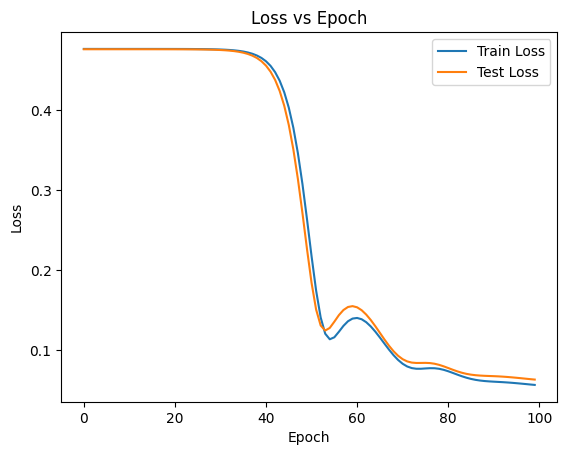

In [151]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

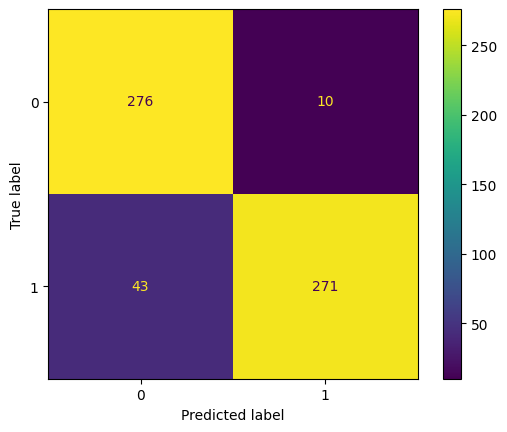

In [152]:
cm = confusion_matrix(y_test, test_outputs.round())
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [153]:
print(f'Accuracy: {accuracy_score(y_test, test_outputs.round())}')
print(f'Report: {classification_report(y_test, test_outputs.round())}')

Accuracy: 0.9116666666666666
Report:               precision    recall  f1-score   support

           0       0.87      0.97      0.91       286
           1       0.96      0.86      0.91       314

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.92      0.91      0.91       600



In [154]:
model_file = 'water_nn.pkl'
file = open(model_file, 'wb')
pkl.dump(model, file)